In [493]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import scipy
from IPython.display import Audio
from scipy.signal import find_peaks
from scipy.signal import butter, sosfilt, sosfreqz

In [494]:
# Cough audio loading
audio_num = 7
cough_audio = "./records/audio-" + str(audio_num) + ".wav"
cough_timestamps = "./timestamps/audio-" + str(audio_num) + "-label.txt"

# Target sample rate: 48000
data, sample_rate = librosa.load(cough_audio, sr=48000)


# Audio duration
duration = librosa.get_duration(path = cough_audio)
total_samples = duration * sample_rate
time = np.arange(0, len(data)) / sample_rate

print("Audio Duration: {}".format(duration))
print("Sample Rate: {}".format(sample_rate))

Audio Duration: 60.138083333333334
Sample Rate: 48000


In [495]:
# Read timestamps text file

f = open(cough_timestamps, "r")
content = f.read()
content = content.split("\n")

real_timestamps = []
for line in content:
    if line != "":
        real_timestamps.append(float(line.split("\t")[0]))


        
print("Real Timestamps: ", real_timestamps)

Real Timestamps:  [7.767075, 25.205261, 47.403537]


In [496]:
# The audio
Audio(cough_audio)

In [497]:
# Filtering of the data

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y

data = butter_bandpass_filter(data, 1000, 4000, sample_rate, 8)

In [498]:
# Data Normalization

def normalize_data(data):
    min = np.min(data)
    max = np.max(data)

    data = (data - min) / (max - min)
    return data

In [499]:
# Moving Average of the Data:
def moving_average(data, window_size=15):
    
    moving_averages = []

    i = 0
    while i < len(data) - window_size + 1:
        
        window = data[i : i + window_size]
        window_average = round(np.sum(window) / window_size, 2)
        moving_averages.append(window_average)

        i += 1    
    
    return np.array(moving_averages)

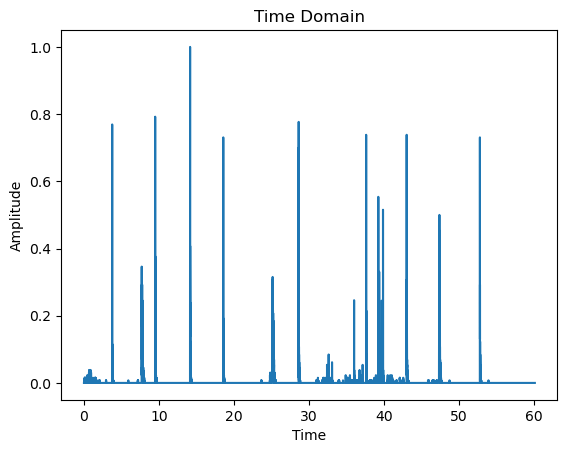

In [500]:
# Graph of moving average of the data and normal data
moving_avg_data = moving_average(np.abs(data))
moving_avg_data = normalize_data(moving_avg_data)

time = np.arange(0, len(moving_avg_data)) / sample_rate
filtered_time = np.arange(0, len(filtered_data_3)) / sample_rate

plt.plot(time, moving_avg_data)

plt.title("Time Domain")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

The shape of spectrogram: (1025, 5638)


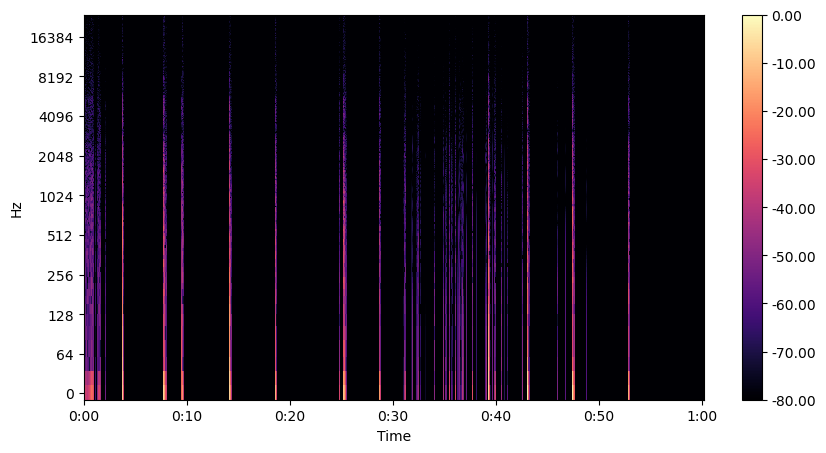

In [501]:
# Spectrogram

D = librosa.stft(moving_avg_data)
S_db = librosa.amplitude_to_db(np.abs(D), ref = np.max)

freqs = librosa.fft_frequencies(sr=sample_rate, n_fft=D.shape[0])

#print(freqs)
print("The shape of spectrogram: {}".format(S_db.shape))

fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(S_db,
                              x_axis="time",
                              y_axis="log",
                              ax=ax,
                              sr = sample_rate,)

fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

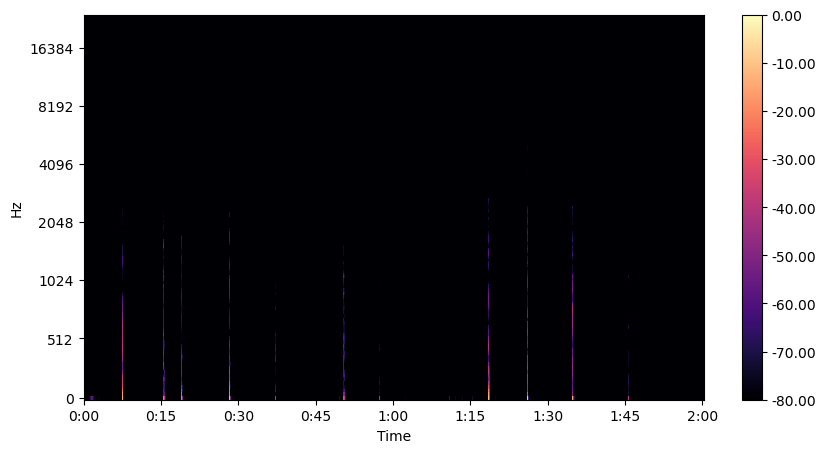

In [502]:
# Mel spectrogram

mel_spectrogram = librosa.feature.melspectrogram(y=moving_avg_data, sr=sample_rate, hop_length=256)
mel_spectrogram_db = librosa.amplitude_to_db(mel_spectrogram, ref=np.max)


fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(mel_spectrogram_db,
                              x_axis="time",
                              y_axis="mel",
                              ax=plt.gca(),
                              sr = sample_rate,)

fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

In [503]:
def detect_coughs(data, percentile_threshold = 99.8):
    
    # Statistics of the data
    max_value = np.max(data)
    mean_value = np.mean(data)
    std = np.std(data)
    data_length = len(data)
    
    # Threshold 
    threshold = np.percentile(data, percentile_threshold)
    
    # Peak detection
    cough_indices, _ = find_peaks(data, prominence = 5)
    cough_indices = list(cough_indices)
    

    #print("Cough indices 1: ", cough_indices)
    #print()

    # Deleting overlaps in the peaks - Avoiding to count same cough more than one
    i = 0
    while i < len(cough_indices):

        peak = cough_indices[i]
        peak_range = (peak - 50, peak + 50) # The range is determined experimentally

        overlap_indices = [index for index in cough_indices
                       if peak_range[0] < index < peak_range[1]]

        if len(overlap_indices) > 1:

            # Find the index with maximum amplitude 
            max = overlap_indices[0]
            for index in overlap_indices:
                if (data[index] > data[max]):
                    max = index

            overlap_indices.remove(max)

            for element in overlap_indices:
                cough_indices.remove(element)

        i += 1
            
    #print("Cough indices 2: ", cough_indices)
    #print()

    # Applying the threshold
    
    cough_indices_copy = list(cough_indices)
    for index in cough_indices_copy: 
        amplitude = data[index]
        if amplitude < threshold:
            cough_indices.remove(index)


    #print("Cough indices 3: ", cough_indices)
    #print()

    # Finding the timestamps of the coughs
    predicted_timestamps = [] 
    for index in cough_indices:
        predicted_timestamps.append(round(index / sample_rate, 6))
    

    # Scaling timestamps according to original recording duration
    for i in range(len(predicted_timestamps)):
        
        actual_index = total_samples * cough_indices[i] / data_length
        actual_timestamp = round(actual_index / sample_rate, 6)
        
        predicted_timestamps[i] = actual_timestamp
    

    # Filtering the sound after coughing
    for ts in predicted_timestamps:
        match = list((ts_2 for ts_2 in predicted_timestamps if ts < ts_2 < ts + 0.4))
        if len(match) != 0:
            index = predicted_timestamps.index(match[0])
            predicted_timestamps.remove(match[0])
            cough_indices.remove(cough_indices[index])
     
    #print("Cough indices 4: ", cough_indices)
    #print()

    return cough_indices, predicted_timestamps

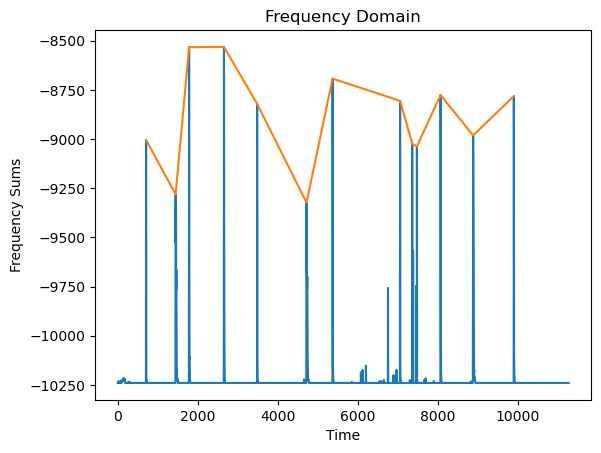


Cough Count: 13
Cough Timestamps: [3.771, 7.707, 9.504, 14.155, 18.581, 25.162, 28.64, 37.642, 39.258, 39.888, 43.04, 47.386, 52.81]
Cough Indices: [707, 1445, 1782, 2654, 3484, 4718, 5370, 7058, 7361, 7479, 8070, 8885, 9902]


In [504]:
# Computing the intervals in frequency bins

sums = []
S_db_tp = np.transpose(mel_spectrogram_db)

for bin in S_db_tp:
    sums.append(np.sum(bin))

sums = np.array(sums)
    
# Applying same formula to the frequency domain
cough_indices , predicted_timestamps = detect_coughs(sums,99)


# Graph
upper_envelope = sums[cough_indices]
time = np.arange(0, len(sums))

# Time envelope
time_envelope = time[cough_indices]


# Graph
plt.plot(time, sums)
plt.plot(time_envelope, upper_envelope)
plt.title("Frequency Domain")
plt.xlabel("Time")
plt.ylabel("Frequency Sums")
plt.show()


# The results
cough_count = len(cough_indices)

print("\nCough Count: {}".format(cough_count))
print("Cough Timestamps: {}".format([round(timestamp, 3) for timestamp in predicted_timestamps]))
print("Cough Indices: {}".format(cough_indices))

In [506]:
# Comparing the real timestamps and predicted timestamps - Performance Measurement

time_margin = 0.05 # In seconds

print(predicted_timestamps)
print(real_timestamps)

true_positive = 0 
false_positive = 0

if (len(predicted_timestamps) > len(real_timestamps)):

    for pred in predicted_timestamps:
        match = list((rt for rt in real_timestamps if pred - 0.4 < rt < pred + 0.4))

        if len(match) != 0:
            true_positive += 1
        else:
            false_positive += 1

else:

    for pred in real_timestamps:
        match = list((rt for rt in predicted_timestamps if pred - 0.4 < rt < pred + 0.4))

        if len(match) != 0:
            true_positive += 1
        else:
            false_positive += 1

precision = true_positive / (true_positive + false_positive)
# Recall is assumed as 1 since the model does not predict the absence of coughs
recall = 1

f1_score = 2 * (precision * recall) / (precision + recall)
print(f1_score)

[3.77063, 7.706592, 9.503908, 14.154529, 18.581153, 25.162423, 28.639722, 37.642302, 39.258286, 39.887613, 43.039583, 47.386207, 52.810154]
[7.767075, 25.205261, 47.403537]
0.375
